#### Outline
1. Data collection
2. Feature Engineering
3. Input Construction
4. GRU Modeling
5. GRU Model Evaluation

## 1. Data collection - Individual Stocks

### Setting Random Seeds

To ensure reproducible results across different runs of the model, we explicitly set random seeds at multiple levels.
These help guarantee that:

- the data splits,
- the weight initialization,
- and other stochastic operations in the pipeline

produce the same output everytime the code is run, assuming the same hardware and software environment. 

This is especially important when comparing model performance, tuning hyperparameters, or performing SHAP explainability.

In [1]:
import os
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
ticker = "CSL"

df = pd.read_csv("combined_stock_data.csv", parse_dates=['Date'])
stock_df = df[df['Name'] == ticker].copy()

# Sort by date
stock_df.sort_values(by='Date', inplace=True)

# Set index
stock_df.set_index('Date', inplace=True)


# Missing values
print("\n Missing values:")
print(stock_df.isnull().sum())  # Count missing values per column
stock_df.dropna(inplace=True)

# Check column and head
print(stock_df.columns)
print(stock_df.head())

# Check the number of rows
freq_counts = stock_df['Name'].value_counts()
print(freq_counts.describe())


 Missing values:
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')
                  Open        High         Low       Close  Volume Name
Date                                                                   
2020-01-02  257.204181  260.732801  256.885955  257.428833  378816  CSL
2020-01-03  262.071225  262.979115  258.505186  259.544098  427336  CSL
2020-01-06  258.327408  259.525447  256.333790  259.076172  398061  CSL
2020-01-07  262.904278  265.815127  260.891922  265.272278  514937  CSL
2020-01-08  268.145697  268.229931  261.154009  267.546692  665873  CSL
count       1.0
mean     1266.0
std         NaN
min      1266.0
25%      1266.0
50%      1266.0
75%      1266.0
max      1266.0
Name: count, dtype: float64


## 📊 2. Features Engineering

These features combine classic time series lags, trend indicators, momentum oscillators, and volatility metrics.  
Grouped below by functional type, they provide rich information for both interpretable models and deep learning models like GRU.

---

### 🕒 Lag Features  
Understand **short-term behavior** via lags and returns.

| Column Name     | Description |
|-----------------|-------------|
| **price_lag1**   | Closing price from 1 day ago – captures immediate price momentum |
| **price_lag2**   | Closing price from 2 days ago – extends short-term memory |
| **return_lag1**  | Percentage return from 1 day ago – normalized price change (%) |

---

### 📈 Trend Indicators  
Capture **trend direction and reversals** using SMA, EMA, and price deviation.

| Column Name     | Description |
|-----------------|-------------|
| **SMA_5**        | 5-day Simple Moving Average – short-term trend average |
| **SMA_20**       | 20-day Simple Moving Average – long-term trend reference |
| **EMA_20**       | 20-day Exponential Moving Average – reacts faster to recent prices |
| **norm_price**   | Price deviation (%) from 20-day MA – normalized position relative to trend |

---

### 🔄 Momentum Indicators  
Measure **momentum and overbought/oversold conditions** via RSI and MACD.

| Column Name     | Description |
|-----------------|-------------|
| **RSI_14**       | 14-day Relative Strength Index – momentum oscillator (0–100 scale). Overbought if >70, Oversold if <30 |
| **MACD**         | Moving Average Convergence Divergence – difference between EMA(12) and EMA(26), indicates momentum direction |
| **MACD_signal**  | 9-day EMA of MACD – signal line used for MACD crossover buy/sell decisions |

---

### 🌊 Volatility Features  
Quantify **volatility and risk** using standard deviation and volatility ratios.

| Column Name       | Description |
|-------------------|-------------|
| **roll_std5**      | 5-day rolling standard deviation – short-term volatility indicator |
| **volatility_5**   | Standard deviation of 5-day returns – recent volatility measure |
| **volatility_20**  | Standard deviation of 20-day returns – longer-term volatility context |
| **vol_ratio**      | Ratio of short-term to long-term volatility (`vol_5 / vol_20`) – reflects market stability shifts |


In [5]:
# Compute daily returns as percentage change in closing price
stock_df['returns'] = stock_df['Close'].pct_change() * 100

# ------------------------------------------
# 🕒 Lag Features
# ------------------------------------------
stock_df['price_lag1'] = stock_df['Close'].shift(1)
stock_df['price_lag2'] = stock_df['Close'].shift(2)
stock_df['return_lag1'] = stock_df['returns'].shift(1)

# ------------------------------------------
# 📈 Trend Indicators
# ------------------------------------------
stock_df['SMA_5'] = stock_df['Close'].rolling(window=5).mean()
stock_df['SMA_20'] = stock_df['Close'].rolling(window=20).mean()
stock_df['EMA_20'] = stock_df['Close'].ewm(span=20, adjust=False).mean()
stock_df['norm_price'] = (stock_df['Close'] - stock_df['SMA_20']) / stock_df['SMA_20'] * 100

# ------------------------------------------
# 🔄 Momentum Indicators
# ------------------------------------------

# RSI (14-day)
delta = stock_df['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
stock_df['RSI_14'] = 100 - (100 / (1 + rs))

# MACD and Signal Line
ema_12 = stock_df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_df['Close'].ewm(span=26, adjust=False).mean()
stock_df['MACD'] = ema_12 - ema_26
stock_df['MACD_signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()

# ------------------------------------------
# 🌊 Volatility Features
# ------------------------------------------
stock_df['roll_std5'] = stock_df['Close'].rolling(window=5).std()
stock_df['volatility_5'] = stock_df['returns'].rolling(window=5).std()
stock_df['volatility_20'] = stock_df['returns'].rolling(window=20).std()
stock_df['vol_ratio'] = stock_df['volatility_5'] / stock_df['volatility_20'].replace(0, np.nan)

In [6]:
# Missing values
print("\n Missing values:")
print(stock_df.isnull().sum())


 Missing values:
Open              0
High              0
Low               0
Close             0
Volume            0
Name              0
returns           1
price_lag1        1
price_lag2        2
return_lag1       2
SMA_5             4
SMA_20           19
EMA_20            0
norm_price       19
RSI_14           13
MACD              0
MACD_signal       0
roll_std5         4
volatility_5      5
volatility_20    20
vol_ratio        20
dtype: int64


It's normal for rolling and shift-based indicators to have NaN values in the initial rows, since they require **past data** to compute.

Especially for models like GRU or CNN where the sequence order is important,
it's common practice to **drop** those initial rows with missing values before training the model.

In [7]:
stock_df.dropna(inplace=True)
print("Final shape after dropping NaNs:", stock_df.shape)

Final shape after dropping NaNs: (1246, 21)


In [8]:
import matplotlib.pyplot as plt

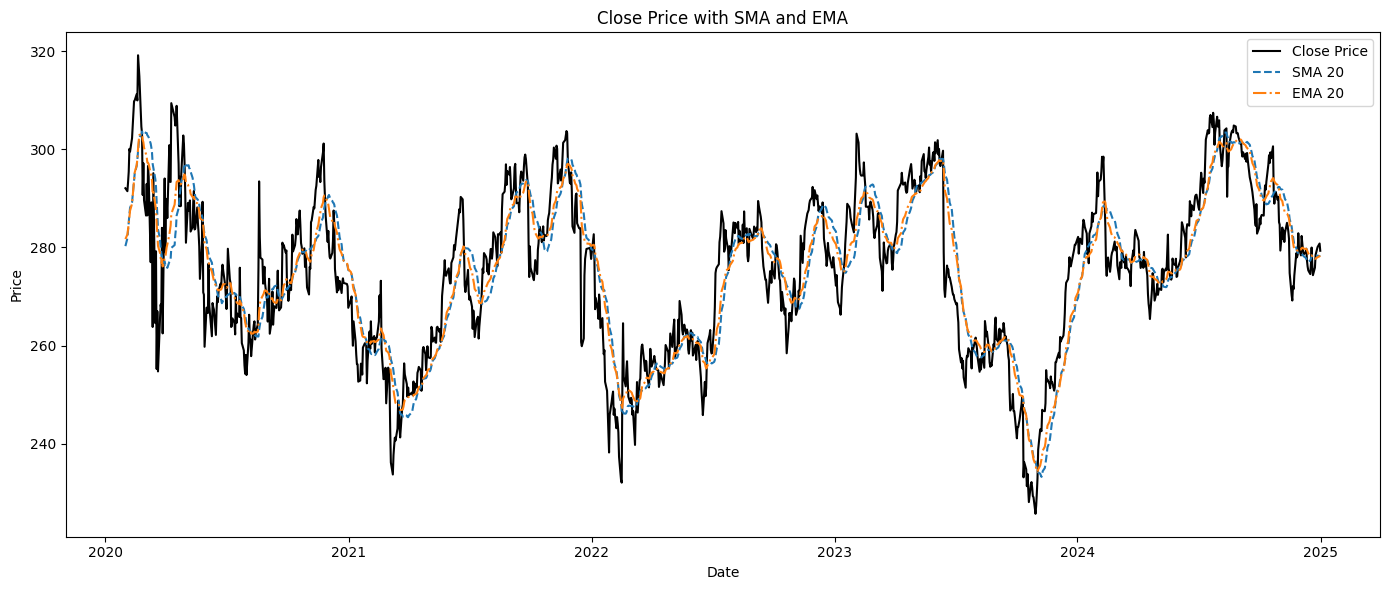

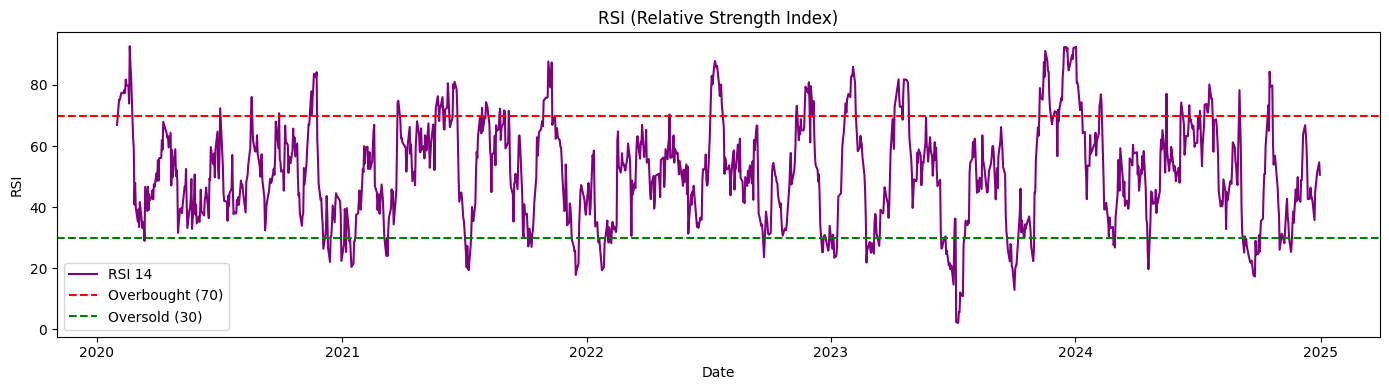

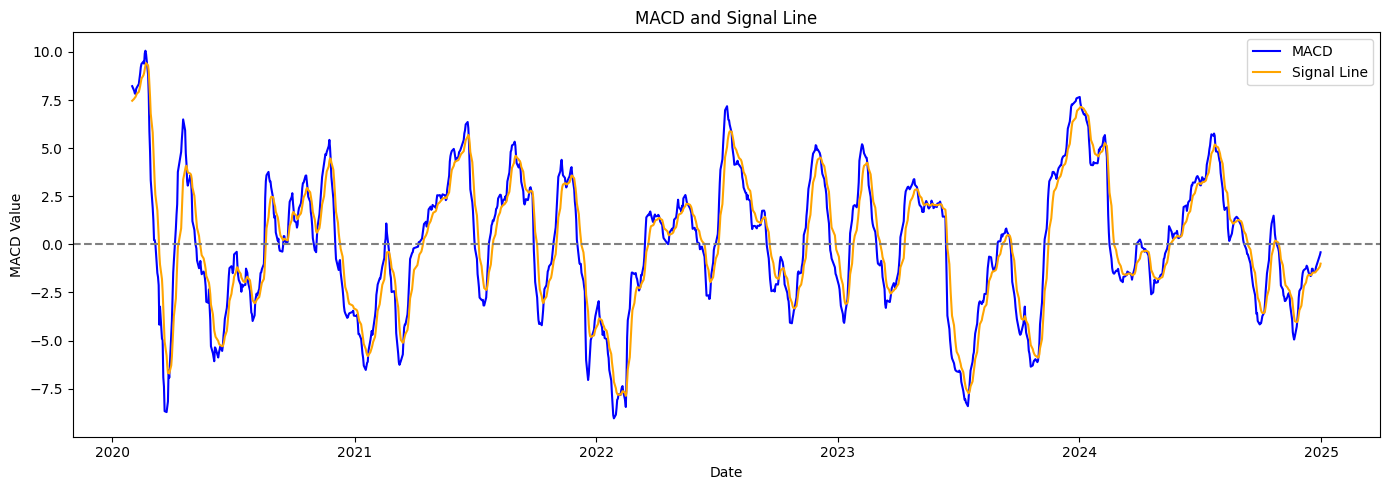

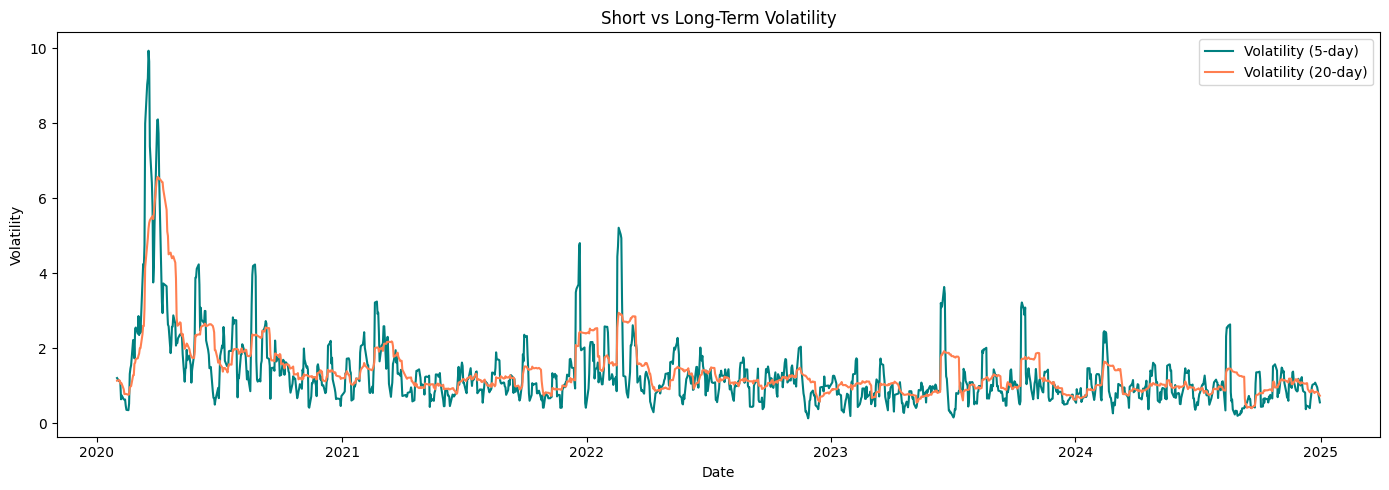

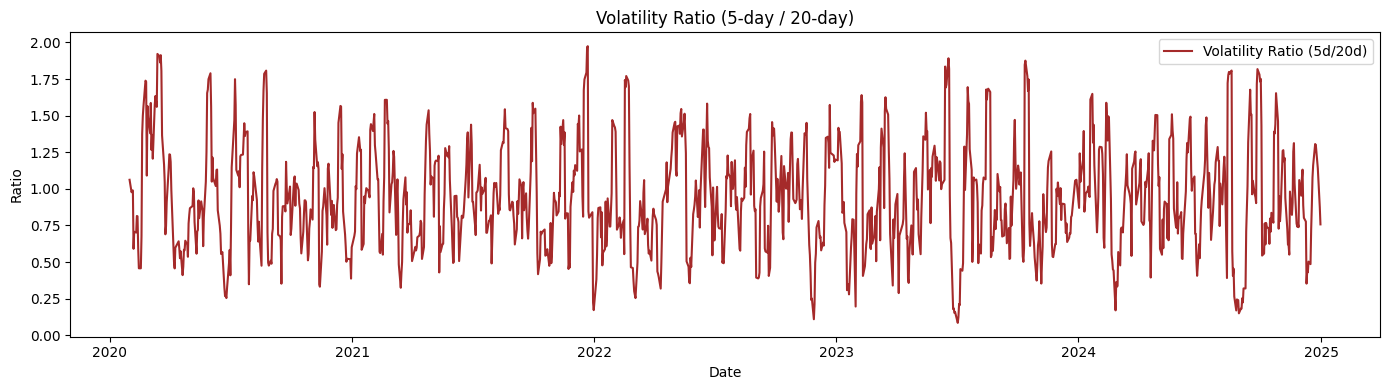

In [9]:
# ----------------------------------------
# 1. Price with SMA & EMA - Helps identify short- and long-term trend movements
# ----------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(stock_df['Close'], label='Close Price', color='black')
plt.plot(stock_df['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(stock_df['EMA_20'], label='EMA 20', linestyle='-.')
plt.title('Close Price with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# 2. RSI - Detects potential overbought and oversold conditions for timing entries/exits
# ----------------------------------------
plt.figure(figsize=(14, 4))
plt.plot(stock_df['RSI_14'], label='RSI 14', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI (Relative Strength Index)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# 3. MACD - Highlights possible trend reversal signals through line crossovers
# ----------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(stock_df['MACD'], label='MACD', color='blue')
plt.plot(stock_df['MACD_signal'], label='Signal Line', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# 4. Volatility: rolling std and volatility ratio - Reveals market instability and periods of sharp fluctuations
# ----------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(stock_df['volatility_5'], label='Volatility (5-day)', color='teal')
plt.plot(stock_df['volatility_20'], label='Volatility (20-day)', color='coral')
plt.title('Short vs Long-Term Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(stock_df['vol_ratio'], label='Volatility Ratio (5d/20d)', color='brown')
plt.title('Volatility Ratio (5-day / 20-day)')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Input Construction

### Objective
Use the past **N day** of time-series as input **X**, and predict either the **closing price D days ahead** or the **price direction (up/down)** as output **Y**.

### Example Setting
- `N = 30`: Use the past 30 days of data as input
- `D = 5`: Predict the closing price (or direction) 5 days into the future

### Required Features
To construct effective input sequences, we include the following engineered features:

- Lag-based prices and returns: `price_lag1`, `return_lag1`, etc.
- Trend indicators: `SMA_5`, `EMA_20`, `norm_price`
- Momentum indicators: `RSI_14`, `MACD`, `MACD_signal`
- Volatility metrics: `volatility_5`, `vol_ratio`

The features are normalized or scaled where necessary to ensure stability in model training.

In [10]:
def create_sequences(data, target_col, N=30, D=5, task='regression'):
    """
    Create input-output sequences for time-series models like GRU or CNN.

    Parameters:
    - data: pandas DataFrame with time-series features
    - target_col: column name to be predicted (e.g., 'Close')
    - N: number of days to use as input (sequence length)
    - D: number of days ahead to predict
    - task: 'regression' or 'classification'

    Returns:
    - X: 3D numpy array (samples, N, features)
    - y: 1D or 2D numpy array of targets
    """

    X = []
    y = []

    features = data.drop(columns=[target_col]).values
    target = data[target_col].values

    for i in range(len(data) - N - D + 1):
        X_seq = features[i:i+N]
        if task == 'regression':
            y_label = target[i+N+D-1]  # Predict D days ahead closing price
        elif task == 'classification':
            y_label = 1 if target[i+N+D-1] > target[i+N-1] else 0  # Price up or down
        else:
            raise ValueError("Task must be 'regression' or 'classification'")

        X.append(X_seq)
        y.append(y_label)

    return np.array(X), np.array(y)

Ensure that only historical data is used to predict future values, in line with the principle of time series forecasting.
- **X**: The past **N days** of input data (e.g., from index `i` to `i+N-1`, representing up to time **t**
- **y**: The target value at **D days after** the input window (i.e., at index `i+N+D-1`), representing a **future time step to be predicted**

In [11]:
feature_cols = ['Volume', 'Open', 'High', 'Low', 'RSI_14', 'MACD', 'MACD_signal',
            'SMA_5', 'SMA_20', 'EMA_20', 'norm_price', 'price_lag1', 'price_lag2',
            'return_lag1', 'volatility_5', 'volatility_20', 'vol_ratio']

target_col = 'Close'  # For regression
seq_df = stock_df[feature_cols + [target_col]].dropna().copy()

# Create sequences
X, y = create_sequences(seq_df, target_col=target_col, N=30, D=1, task='regression')

print("✅ Sequences created:")
print("X shape:", X.shape)  # (samples, 30, features)
print("y shape:", y.shape)  # (samples,)

✅ Sequences created:
X shape: (1216, 30, 17)
y shape: (1216,)


## 4. GRU Modeling

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

### Data Preprocessing

In [13]:
# Feature scaling (optional but recommended for GRU)
X_reshaped = X.reshape(-1, X.shape[-1])  # (1212*30, 13)
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)  # (1212, 30, 13)

# y scaling (for regression)
y = y.reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaler.fit(y)  # fit only once
y_scaled = y_scaler.transform(y)  # transform separately

### Train/Validation Split for Time Series

In [14]:
split_index = int(len(X_scaled) * 0.8)

# Training set: the first 80% of the sequence
X_train = X_scaled[:split_index]
y_train = y_scaled[:split_index]

# Validation set: the most recent 20%
X_val = X_scaled[split_index:]
y_val = y_scaled[split_index:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (972, 30, 17)
X_val shape: (244, 30, 17)


- The temporal sequence must not be broken.
- **Using recent data as validation** allows us to test how the model would behave on unseen, future-like data.
- Once the model architecture is reasonably finaised, expand to **TimeSeriesSplit** for evaluating performance stability and implementing cross-validated GRU training.

### Build GRU model

In [15]:
# Set input dimensions
timesteps = X_train.shape[1]  # ➜ 30 (N-day input window)
features = X_train.shape[2]   # ➜ 13 (number of input features per time step)

# Build GRU model
gru_model = Sequential([
    GRU(64, input_shape=(timesteps, features), return_sequences=False), # Encodes the input sequence into a 64-dimensional representation
    Dropout(0.2), # Randomly drops a portion of the units during training to prevent overfitting
    Dense(32, activation='relu'), # Fully connected layer
    Dense(1)  # Regression output
])

gru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

gru_model.summary()

C:\Users\jiyoo\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        15,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train GRU model

- `loss`: Mean Squared Error (MSE) on the training set  
- `val_loss`: Mean Squared Error (MSE) on the validation set

**🧠 Interpretation Guide**

| Pattern                | Interpretation                                                                 |
|------------------------|---------------------------------------------------------------------------------|
| `loss ↓`, `val_loss ↓` | The model is learning well and improving over time                            |
| `loss ↓`, `val_loss ↑` | Possible overfitting – the model fits training data well but does not generalize  |
| `loss ≈ val_loss`, high values | Stable learning but performance still has room for improvement               |


**✅ MAE (Mean Absolute Error)**

If `metrics=['mae']` is specified during model compilation,  
then `val_mae` represents the **average absolute difference** between predicted and actual values on the validation set.

**📈 Predicted vs Actual Plot Patterns**

| Pattern                                  | Interpretation                                                              |
|------------------------------------------|------------------------------------------------------------------------------|
| Lines closely overlap                    | Strong prediction performance                                             |
| Trend is correct but scale is off       | Scaling or normalization might need adjustment                             |
| Predictions are flat or unresponsive     | Model may be too simple or input sequence too short                        |
| Predictions fluctuate excessively        | Possible overfitting or noisy data                                          |


In [16]:
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1, # Display training progress during each epoch
    shuffle=False # Disable shuffling to preserve time series order
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1663 - mae: 0.3090 - val_loss: 0.0039 - val_mae: 0.0495
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0200 - mae: 0.1105 - val_loss: 0.0041 - val_mae: 0.0506
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0145 - mae: 0.0922 - val_loss: 0.0061 - val_mae: 0.0651
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0120 - mae: 0.0833 - val_loss: 0.0054 - val_mae: 0.0619
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0098 - mae: 0.0751 - val_loss: 0.0026 - val_mae: 0.0407
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0097 - mae: 0.0759 - val_loss: 0.0063 - val_mae: 0.0689
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0080 - mae: 0.0688 - val_loss: 0.0024 - val_mae: 0.0398
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - mae: 0.0674 - val_loss: 0.0035 - val_mae: 0.0498
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.007

### Prediction and Visualisation
*The model trains on normalised data above, while interpretation is done on the original scale.*

*Make sure to use `X` and `y` generated after `.dropna()`, as mismatched lengths between `y_val` and `y_pred` can cause errors.*

*To zoom in, we can plot a subset like `plt.plot(y_val[:100])` for better visual clarity.*

In [17]:
# Predict
gru_y_pred = gru_model.predict(X_val)

# Inverse transform
gru_y_pred = y_scaler.inverse_transform(gru_y_pred)
gru_y_val = y_scaler.inverse_transform(y_val)

gru_index = stock_df.index[-len(gru_y_val):]

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


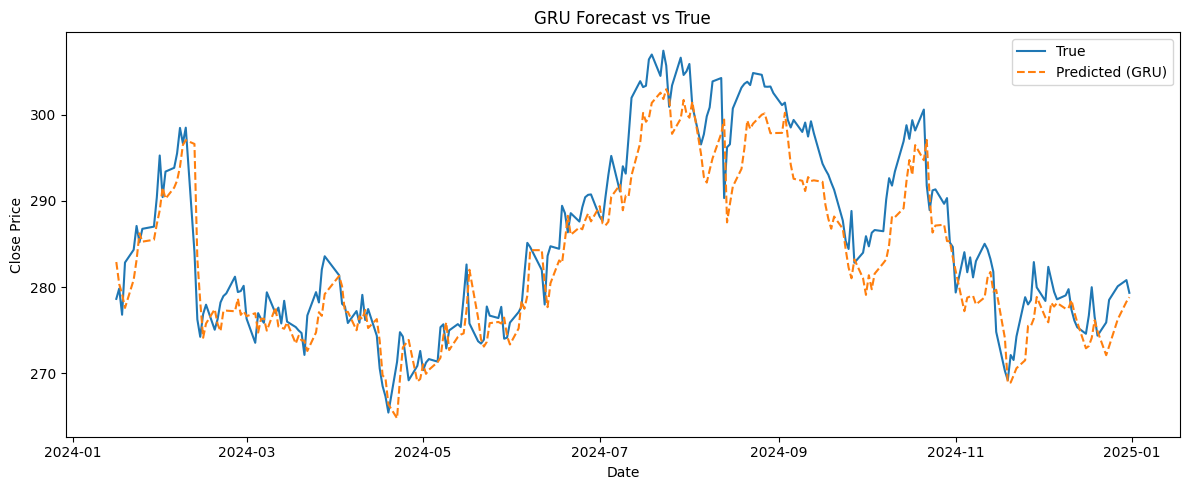

In [18]:
# Visualise
plt.figure(figsize=(12, 5))
plt.plot(gru_index, gru_y_val, label='True')
plt.plot(gru_index, gru_y_pred, label='Predicted (GRU)', linestyle='--')
plt.title('GRU Forecast vs True')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

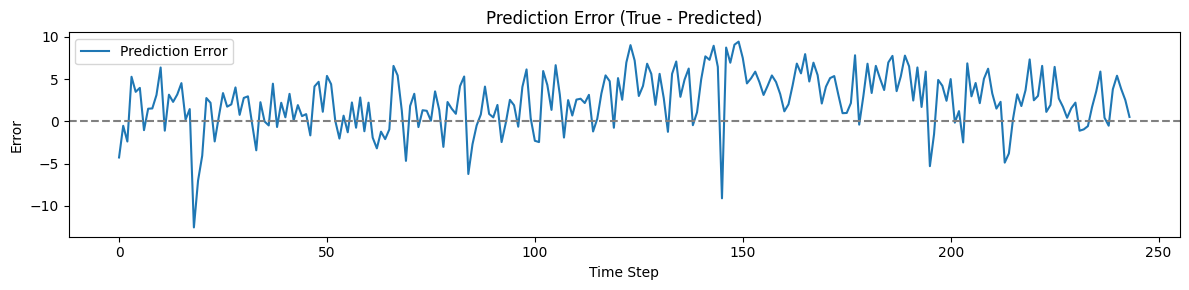

In [19]:
plt.figure(figsize=(12, 3))
plt.plot(gru_y_val - gru_y_pred, label='Prediction Error')
plt.title('Prediction Error (True - Predicted)')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

## 5. GRU Model Evaluation

### 5-1. Quantitative Evaluation
*While we've already reviewed common metrics like **loss, MAE, and val_loss**, it's helpful to include additional evaluation metrics to get a more complete picture of model performance.*

- **RMSE (Root Mean Squared Error)**: Measures the square root of the average squared difference between predicted and actual values. Penalizes large errors more heavily. A lower RMSE indicates better model accuracy.
- **MAPE (Mean Absolute Percentage Error)**: Expresses prediction error as a percentage of the actual values. It shows, on average, how far off the predictions are in relative terms. Lower is better.
- **$R^2$ Score (Coefficient of Determination)**: Represents how well the model explains the variance in the target variable. Ranges from 0 to 1 (closer to 1 is better). A negative value means the model performs worse than a horizontal line (mean predictor).

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [21]:
gru_rmse = np.sqrt(mean_squared_error(gru_y_val, gru_y_pred))
gru_mae = mean_absolute_error(gru_y_val, gru_y_pred)
gru_mape = mean_absolute_percentage_error(gru_y_val, gru_y_pred)
gru_r2 = r2_score(gru_y_val, gru_y_pred)

print("📊 GRU Performance:")
print(f"RMSE: {gru_rmse:.4f}")
print(f"MAE: {gru_mae:.4f}")
print(f"MAPE: {gru_mape:.4%}")
print(f"R² Score: {gru_r2:.4f}")

📊 GRU Performance:
RMSE: 4.1325
MAE: 3.4020
MAPE: 1.1785%
R² Score: 0.8460


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━

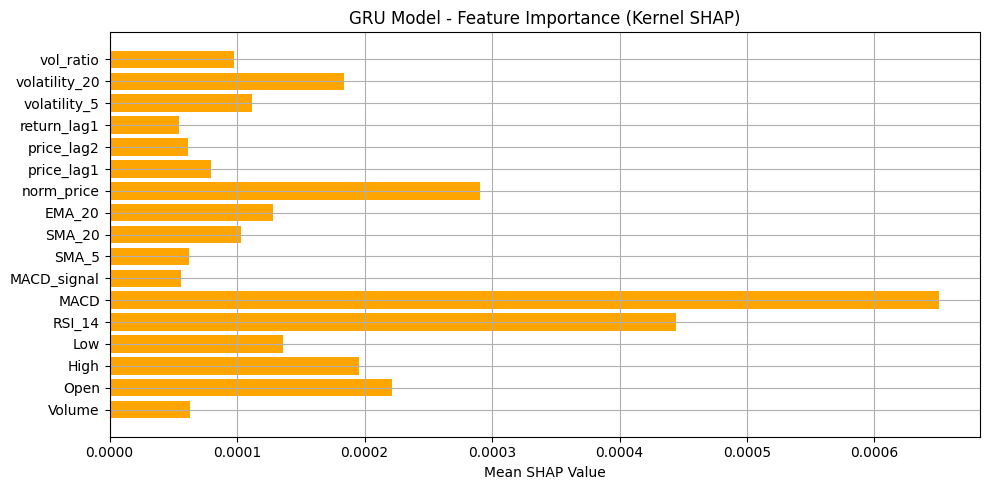

In [22]:
import shap

# Flatten input for KernelExplainer: [samples, features * timesteps]
X_kernel = X_val[:20].reshape(20, -1)
X_bg = X_train[:50].reshape(50, -1)

# Define a prediction function
def model_predict(x):
    return gru_model.predict(x.reshape(-1, X_train.shape[1], X_train.shape[2]))

explainer = shap.KernelExplainer(model_predict, X_bg)
shap_values_gru = explainer.shap_values(X_kernel, nsamples=200)

# Average feature importance
shap_array = np.abs(shap_values_gru).mean(axis=0)
feature_importance = shap_array.reshape(X_train.shape[1], X_train.shape[2]).mean(axis=0)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.barh(range(len(feature_cols)), feature_importance, color='orange')
plt.yticks(range(len(feature_cols)), feature_cols)
plt.xlabel("Mean SHAP Value")
plt.title("GRU Model - Feature Importance (Kernel SHAP)")
plt.grid(True)
plt.tight_layout()
plt.show()

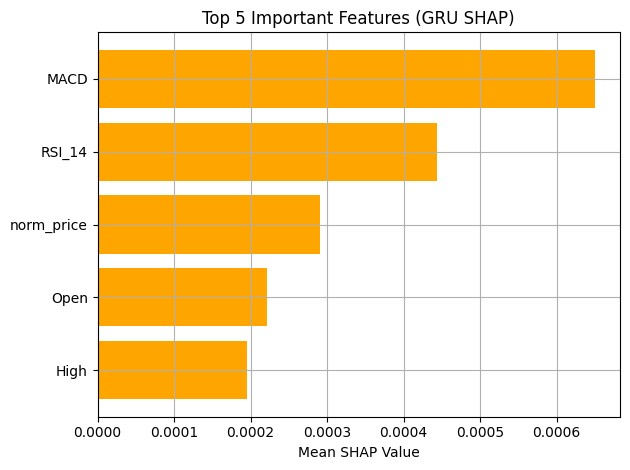

In [25]:
top_k = 5
top_indices = np.argsort(feature_importance)[-top_k:]

plt.barh(np.array(feature_cols)[top_indices], feature_importance[top_indices], color='orange')
plt.xlabel("Mean SHAP Value")
plt.title("Top 5 Important Features (GRU SHAP)")
plt.tight_layout()
plt.grid(True)
plt.show()


# Fine-Tuned GRU with More Features

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

#Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(stock_df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols, index=stock_df.index)


# Build a fine-tuned GRU model
fine_tuned_gru = Sequential()
fine_tuned_gru.add(GRU(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
fine_tuned_gru.add(Dropout(0.3))
fine_tuned_gru.add(GRU(64))
fine_tuned_gru.add(Dense(32, activation='relu'))
fine_tuned_gru.add(Dense(1))
fine_tuned_gru.compile(optimizer=Adam(0.0005), loss='mse', metrics=['mae'])

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_fine = fine_tuned_gru.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, callbacks=[early_stop], verbose=1, shuffle=False)

# Predict on validation set
fine_tuned_gru_y_pred = fine_tuned_gru.predict(X_val)

# Inverse transform predictions and targets
fine_tuned_gru_y_pred_inv = y_scaler.inverse_transform(fine_tuned_gru_y_pred)
y_val_inv = y_scaler.inverse_transform(y_val)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_val_inv, fine_tuned_gru_y_pred_inv))
mae = mean_absolute_error(y_val_inv, fine_tuned_gru_y_pred_inv)
r2 = r2_score(y_val_inv, fine_tuned_gru_y_pred_inv)

print(f"📊 Fine-Tuned GRU Performance — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0690 - mae: 0.1935 - val_loss: 0.0083 - val_mae: 0.0748
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0142 - mae: 0.0935 - val_loss: 0.0069 - val_mae: 0.0703
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0091 - mae: 0.0742 - val_loss: 0.0030 - val_mae: 0.0417
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0084 - mae: 0.0710 - val_loss: 0.0027 - val_mae: 0.0394
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0087 - mae: 0.0704 - val_loss: 0.0026 - val_mae: 0.0383
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0071 - mae: 0.0644 - val_loss: 0.0025 - val_mae: 0.0382
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0062 - mae: 0.0616 - val_loss: 0.0031 - val_mae: 0.0449
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0064 - mae: 0.0612 - val_loss: 0.0023 - val_mae: 0.0376
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - lo

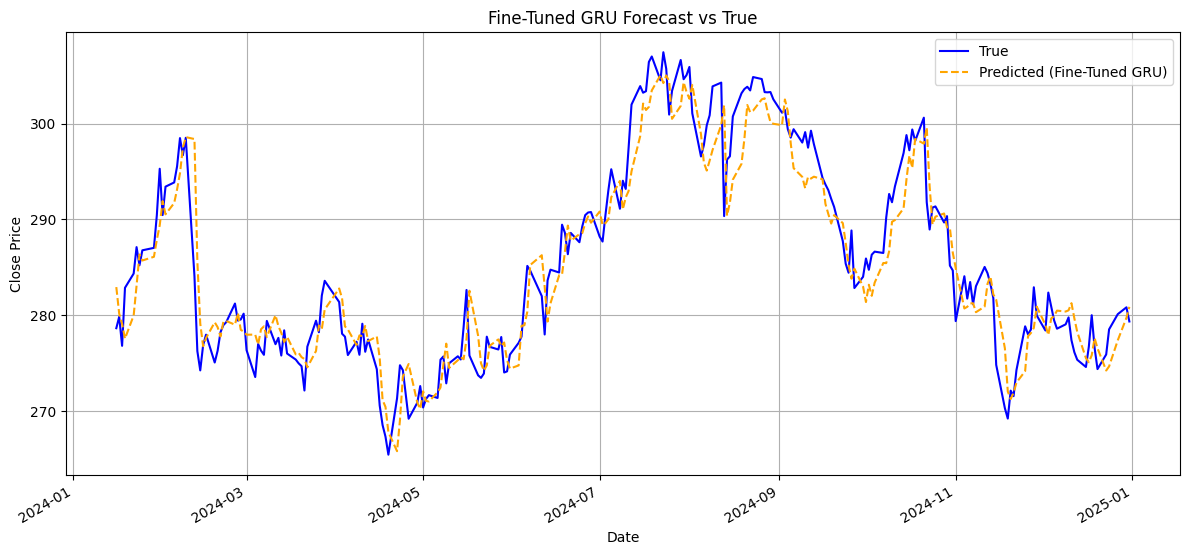

In [27]:
# ✅ Match index to real validation dates
val_dates = stock_df.index[-len(y_val_inv):]

# ✅ Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(val_dates, y_val_inv, label='True', color='blue')
plt.plot(val_dates, fine_tuned_gru_y_pred_inv, label='Predicted (Fine-Tuned GRU)', color='orange', linestyle='--')
plt.title("Fine-Tuned GRU Forecast vs True")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# SHAP Analysis of Updated GRU

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


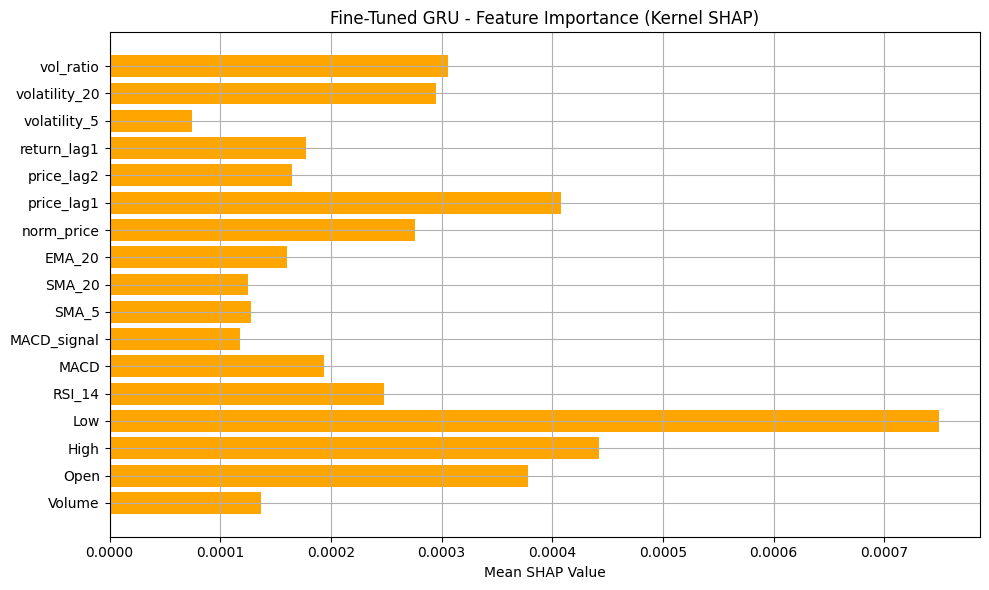

In [28]:
# 1. Select sample sequences for explanation
X_val_sample = X_val[:10]  # Select 10 samples for SHAP
background_sample = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]  # 50 samples for background

# 2. Flatten the sequences for SHAP input (samples, timesteps * features)
X_val_flat = X_val_sample.reshape((X_val_sample.shape[0], -1))
background_flat = background_sample.reshape((background_sample.shape[0], -1))

# 3. Define prediction function compatible with KernelExplainer
#    Reshapes the flat input back to 3D format expected by the model
def predict_flat(X_flat):
    X_reshaped = X_flat.reshape(-1, X.shape[1], X.shape[2])
    return fine_tuned_gru.predict(X_reshaped)

# 4. Initialize SHAP KernelExplainer with the prediction function
explainer = shap.KernelExplainer(predict_flat, background_flat)

# 5. Compute SHAP values for the selected validation samples
shap_values_fine_gru = explainer.shap_values(X_val_flat, nsamples=200)

# 6. Squeeze to remove any singleton dimensions and reshape to (samples, timesteps, features)
shap_arr = np.squeeze(np.array(shap_values_fine_gru))
shap_reshaped = shap_arr.reshape(X_val_sample.shape[0], X.shape[1], X.shape[2])

# 7. Aggregate SHAP values: mean over time, then mean over samples
mean_shap_timestep = np.mean(np.abs(shap_reshaped), axis=1)
mean_feature_importance = np.mean(mean_shap_timestep, axis=0)

# 8. Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_cols, mean_feature_importance, color='orange')
plt.xlabel("Mean SHAP Value")
plt.title("Fine-Tuned GRU - Feature Importance (Kernel SHAP)")
plt.grid(True)
plt.tight_layout()
plt.show()


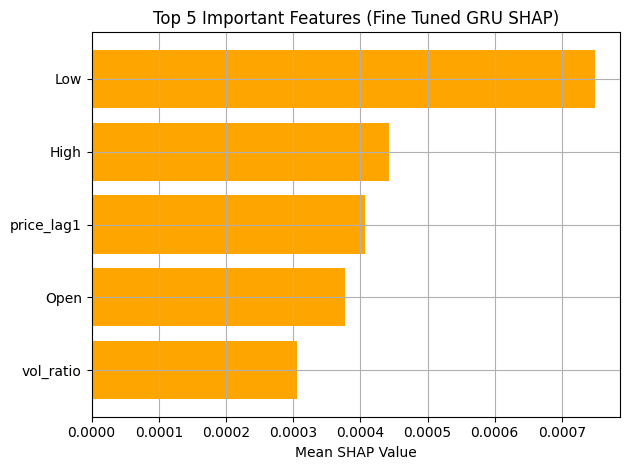

In [29]:
top_k = 5
top_indices = np.argsort(mean_feature_importance)[-top_k:]

plt.barh(np.array(feature_cols)[top_indices], mean_feature_importance[top_indices], color='orange')
plt.xlabel("Mean SHAP Value")
plt.title("Top 5 Important Features (Fine Tuned GRU SHAP)")
plt.tight_layout()
plt.grid(True)
plt.show()


# Build CNN

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0758 - mae: 0.2198 - val_loss: 0.0513 - val_mae: 0.2092
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0205 - mae: 0.1144 - val_loss: 0.0294 - val_mae: 0.1533
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - mae: 0.1036 - val_loss: 0.0357 - val_mae: 0.1731
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0138 - mae: 0.0918 - val_loss: 0.0343 - val_mae: 0.1699
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128 - mae: 0.0884 - val_loss: 0.0287 - val_mae: 0.1547
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118 - mae: 0.0853 - val_loss: 0.0272 - val_mae: 0.1502
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - mae: 0.0810 - val_loss: 0.0334 - val_mae: 0.1691
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - mae: 0.0746 - val_loss: 0.0366 - val_mae: 0.1778
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.00

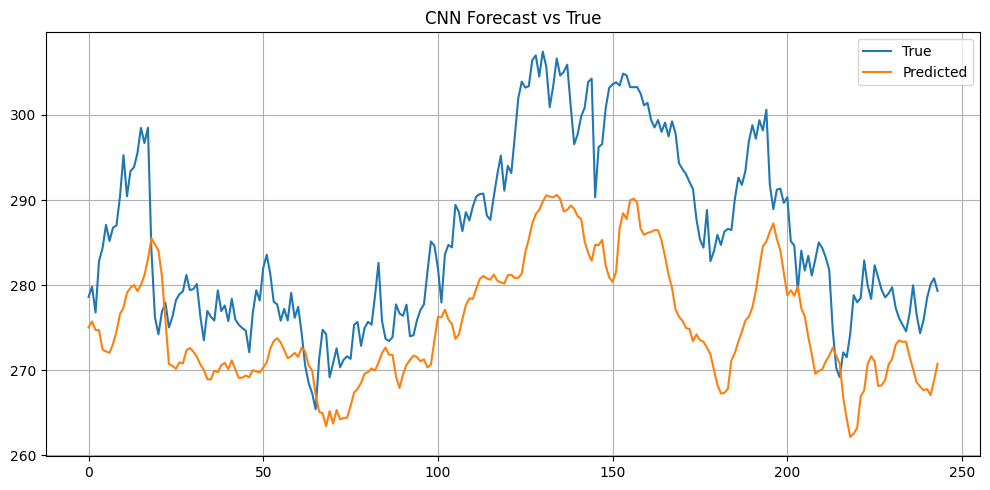

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 7. Build CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1))

cnn_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# 8. Train
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 9. Predict and inverse transform
cnn_y_pred = cnn_model.predict(X_val)
cnn_y_val_inv = y_scaler.inverse_transform(y_val)
cnn_y_pred_inv = y_scaler.inverse_transform(cnn_y_pred)

# 10. Evaluation
cnn_rmse = np.sqrt(mean_squared_error(cnn_y_val_inv, cnn_y_pred_inv))
cnn_mae = mean_absolute_error(cnn_y_val_inv, cnn_y_pred_inv)
cnn_r2 = r2_score(cnn_y_val_inv, cnn_y_pred_inv)

print(f"✅ CNN Performance — RMSE: {cnn_rmse:.4f}, MAE: {cnn_mae:.4f}, R²: {cnn_r2:.4f}")

# 11. Plot results
plt.figure(figsize=(10, 5))
plt.plot(cnn_y_val_inv, label='True')
plt.plot(cnn_y_pred_inv, label='Predicted')
plt.legend()
plt.title("CNN Forecast vs True")
plt.grid(True)
plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


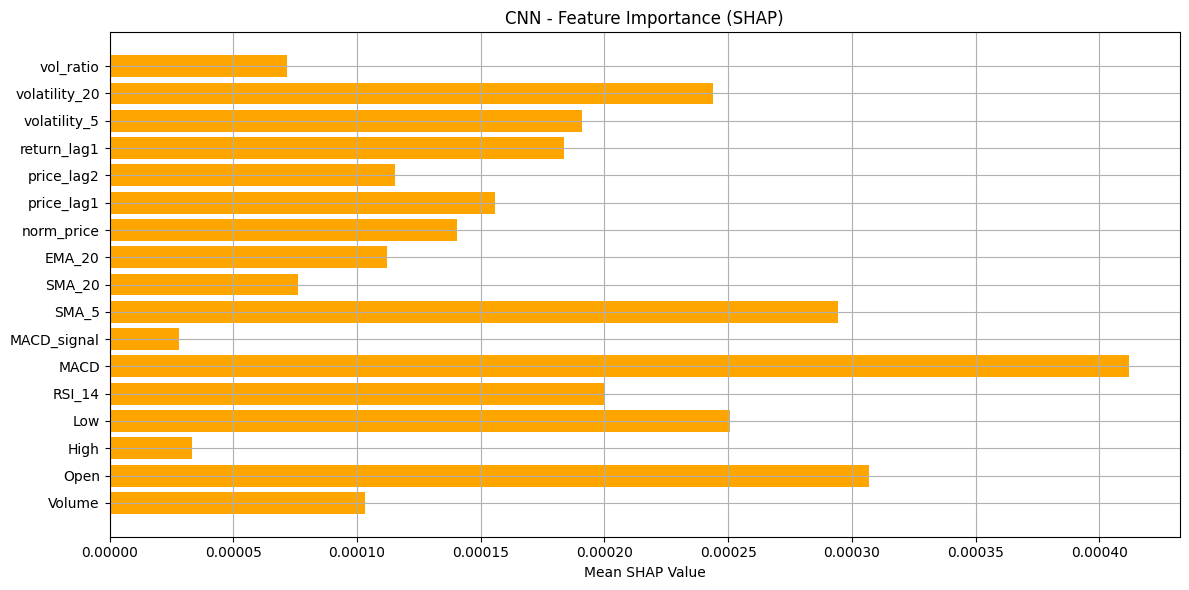

In [31]:
# 1. Sample sequences for SHAP explanation (10 samples for demo)
X_val_sample = X_val[:10]

# 2. Prepare background sample (random from training data)
background_sample = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

# 3. Flatten sequences for KernelExplainer (samples, timesteps * features)
X_val_flat = X_val_sample.reshape((X_val_sample.shape[0], -1))
background_flat = background_sample.reshape((background_sample.shape[0], -1))

# 4. Define prediction function that reshapes back for the model
def predict_flat(X_flat):
    X_reshaped = X_flat.reshape(-1, X.shape[1], X.shape[2])
    return cnn_model.predict(X_reshaped)

# 5. Initialize KernelExplainer
explainer = shap.KernelExplainer(predict_flat, background_flat)

# 6. Compute SHAP values (this can take a few minutes)
shap_values_cnn = explainer.shap_values(X_val_flat, nsamples=200)

# 7. Reshape SHAP values back to (samples, timesteps, features)
shap_arr = np.array(shap_values_cnn).squeeze()  # Shape: (10, timesteps * features)
shap_arr = shap_arr.reshape(X_val_sample.shape[0], X_val_sample.shape[1], X_val_sample.shape[2])

# 8. Aggregate SHAP values
# Mean over time (timesteps), then mean over samples to get (features,)
mean_shap_time = np.mean(np.abs(shap_arr), axis=1)
mean_feature_importance = np.mean(mean_shap_time, axis=0)

# 9. Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(feature_cols, mean_feature_importance, color='orange')
plt.xlabel("Mean SHAP Value")
plt.title("CNN - Feature Importance (SHAP)")
plt.tight_layout()
plt.grid(True)
plt.show()


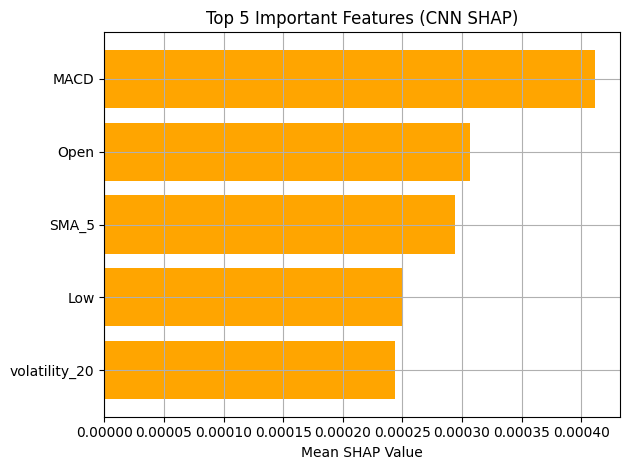

In [32]:
top_k = 5
top_indices = np.argsort(mean_feature_importance)[-top_k:]

plt.barh(np.array(feature_cols)[top_indices], mean_feature_importance[top_indices], color='orange')
plt.xlabel("Mean SHAP Value")
plt.title("Top 5 Important Features (CNN SHAP)")
plt.tight_layout()
plt.grid(True)
plt.show()


# CNN hybird Model

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.1606 - mae: 0.3154 - val_loss: 0.0237 - val_mae: 0.1301
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165 - mae: 0.1032 - val_loss: 0.0082 - val_mae: 0.0701
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - mae: 0.0849 - val_loss: 0.0070 - val_mae: 0.0658
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0109 - mae: 0.0823 - val_loss: 0.0060 - val_mae: 0.0606
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0089 - mae: 0.0743 - val_loss: 0.0047 - val_mae: 0.0535
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0082 - mae: 0.0699 - val_loss: 0.0048 - val_mae: 0.0548
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0075 - mae: 0.0672 - val_loss: 0.0047 - val_mae: 0.0542
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0074 - mae: 0.0677 - val_loss: 0.0040 - val_mae: 0.0500
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

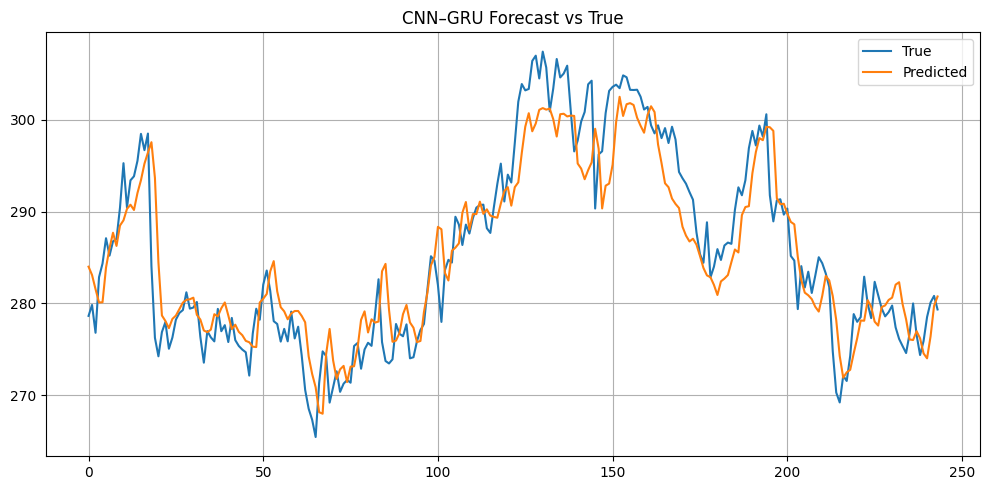

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 7. Build CNN–GRU Hybrid Model
hybrid_model = Sequential()
hybrid_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
hybrid_model.add(MaxPooling1D(pool_size=2))
hybrid_model.add(Dropout(0.3))
hybrid_model.add(GRU(64, return_sequences=True))
hybrid_model.add(GRU(32))
hybrid_model.add(Dense(32, activation='relu'))
hybrid_model.add(Dense(1))

hybrid_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# 8. Train
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hybrid_history = hybrid_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 9. Predict and inverse transform
hybrid_y_pred = hybrid_model.predict(X_val)
hybrid_y_val_inv = y_scaler.inverse_transform(y_val)
hybrid_y_pred_inv = y_scaler.inverse_transform(hybrid_y_pred)

# 10. Evaluation
hybrid_rmse = np.sqrt(mean_squared_error(hybrid_y_val_inv, hybrid_y_pred_inv))
hybrid_mae = mean_absolute_error(hybrid_y_val_inv, hybrid_y_pred_inv)
hybrid_r2 = r2_score(hybrid_y_val_inv, hybrid_y_pred_inv)

print(f"✅ Hybrid CNN–GRU Performance — RMSE: {hybrid_rmse:.4f}, MAE: {hybrid_mae:.4f}, R²: {hybrid_r2:.4f}")

# 11. Plot results
plt.figure(figsize=(10, 5))
plt.plot(hybrid_y_val_inv, label='True')
plt.plot(hybrid_y_pred_inv, label='Predicted')
plt.legend()
plt.title("CNN–GRU Forecast vs True")
plt.grid(True)
plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


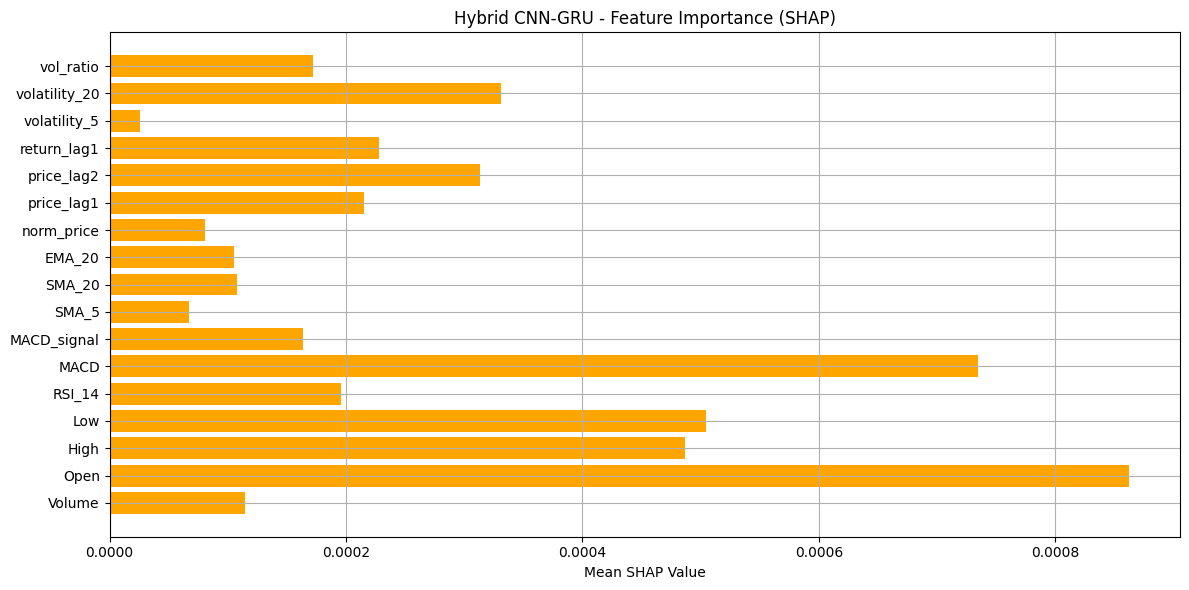

In [34]:
# 1. Sample sequences for SHAP explanation (10 samples for demo)
X_val_sample = X_val[:10]

# 2. Prepare background sample (random from training data)
background_sample = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

# 3. Flatten sequences for KernelExplainer (samples, timesteps * features)
X_val_flat = X_val_sample.reshape((X_val_sample.shape[0], -1))
background_flat = background_sample.reshape((background_sample.shape[0], -1))

# 4. Define prediction function that reshapes back for the model
def predict_flat(X_flat):
    X_reshaped = X_flat.reshape(-1, X.shape[1], X.shape[2])
    return hybrid_model.predict(X_reshaped)

# 5. Initialize KernelExplainer
explainer = shap.KernelExplainer(predict_flat, background_flat)

# 6. Compute SHAP values (this can take a few minutes)
shap_values_hybrid = explainer.shap_values(X_val_flat, nsamples=200)

# 7. Reshape SHAP values back to (samples, timesteps, features)
shap_arr = np.array(shap_values_hybrid).squeeze()  # Shape: (10, timesteps * features)
shap_arr = shap_arr.reshape(X_val_sample.shape[0], X_val_sample.shape[1], X_val_sample.shape[2])

# 8. Aggregate SHAP values
# Mean over time (timesteps), then mean over samples to get (features,)
mean_shap_time = np.mean(np.abs(shap_arr), axis=1)
mean_feature_importance = np.mean(mean_shap_time, axis=0)

# 9. Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(feature_cols, mean_feature_importance, color='orange')
plt.xlabel("Mean SHAP Value")
plt.title("Hybrid CNN-GRU - Feature Importance (SHAP)")
plt.tight_layout()
plt.grid(True)
plt.show()


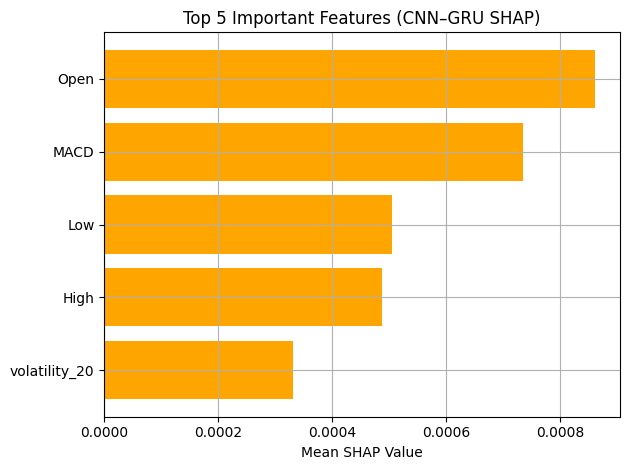

In [35]:
top_k = 5
top_indices = np.argsort(mean_feature_importance)[-top_k:]

plt.barh(np.array(feature_cols)[top_indices], mean_feature_importance[top_indices], color='orange')
plt.xlabel("Mean SHAP Value")
plt.title("Top 5 Important Features (CNN–GRU SHAP)")
plt.tight_layout()
plt.grid(True)
plt.show()


In [36]:
for layer in hybrid_model.layers:
    print(layer.name)

conv1d_2
max_pooling1d_2
dropout_3
gru_3
gru_4
dense_6
dense_7


# Build Grad-CAM

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Functional Input
input_tensor = tf.keras.Input(shape=X_val.shape[1:])

# Pass input through the model and automatically capture the first Conv1D layer's output
x = input_tensor
target_conv_output = None

for layer in hybrid_model.layers:
    x = layer(x)
    if isinstance(layer, tf.keras.layers.Conv1D) and target_conv_output is None:
        target_conv_output = x  # Capture the first Conv1D output

# Build the Grad-CAM model
grad_model = tf.keras.models.Model(inputs=input_tensor, outputs=[target_conv_output, x])

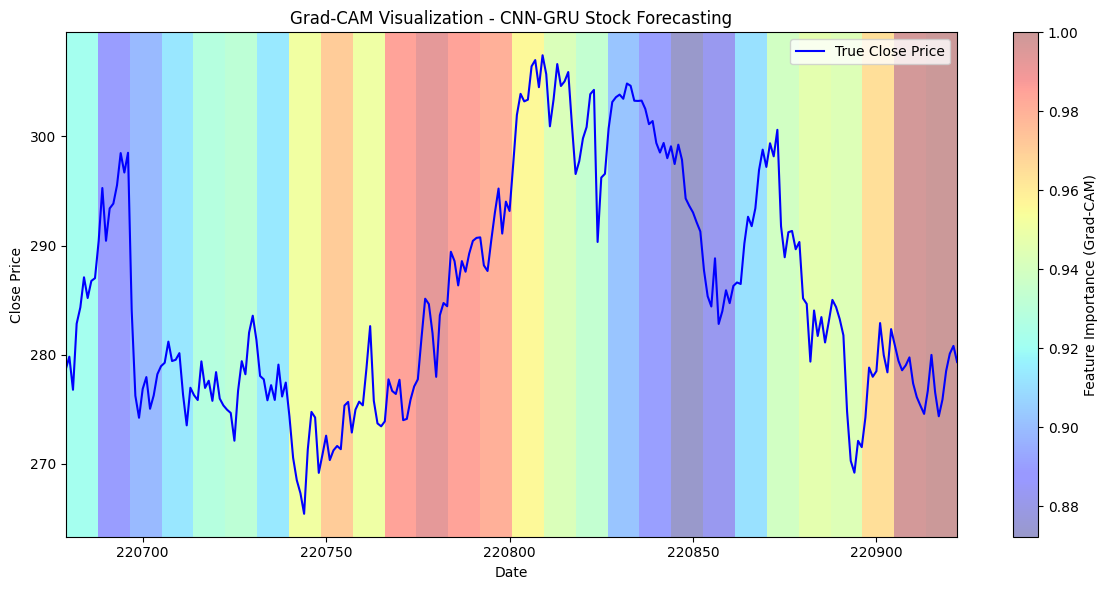

In [38]:
# Input sample
input_sequence = X_val[[-1]]  # shape: (1, timesteps, features)

# Gradient computation
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(input_sequence)
    loss = predictions[:, 0]

# Gradients of loss w.r.t conv outputs
grads = tape.gradient(loss, conv_outputs)

# Global Average Pooling on gradients
pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

# Weight conv outputs by pooled grads
conv_outputs = conv_outputs[0]  # Remove batch dim
heatmap = tf.reduce_sum(conv_outputs * pooled_grads[:, tf.newaxis], axis=-1)

# ReLU & Normalize
heatmap = tf.nn.relu(heatmap)
heatmap = heatmap / tf.reduce_max(heatmap)

# ✅ Visualization
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(X_val):], y_val_inv, label='True Close Price', color='blue')
plt.title("Grad-CAM Visualization - CNN-GRU Stock Forecasting")
plt.xlabel("Date")
plt.ylabel("Close Price")

plt.imshow(heatmap.numpy()[np.newaxis, :], aspect='auto', cmap='jet',
           extent=[df.index[-len(X_val):][0], df.index[-1], plt.ylim()[0], plt.ylim()[1]],
           alpha=0.4)

plt.colorbar(label='Feature Importance (Grad-CAM)')
plt.legend()
plt.tight_layout()
plt.show()

# Build Multivariate Linear Regression (Flatten based) - to directly compare with other models

- Apply Linear Regression using the same `X_train` and `X_val` data as other models, after flattening the 3D input. 

In [40]:
from sklearn.linear_model import LinearRegression

📊 Linear Regression (flattened GRU input) Performance:
RMSE: 3.8763, MAE: 3.1236, R²: 0.8645


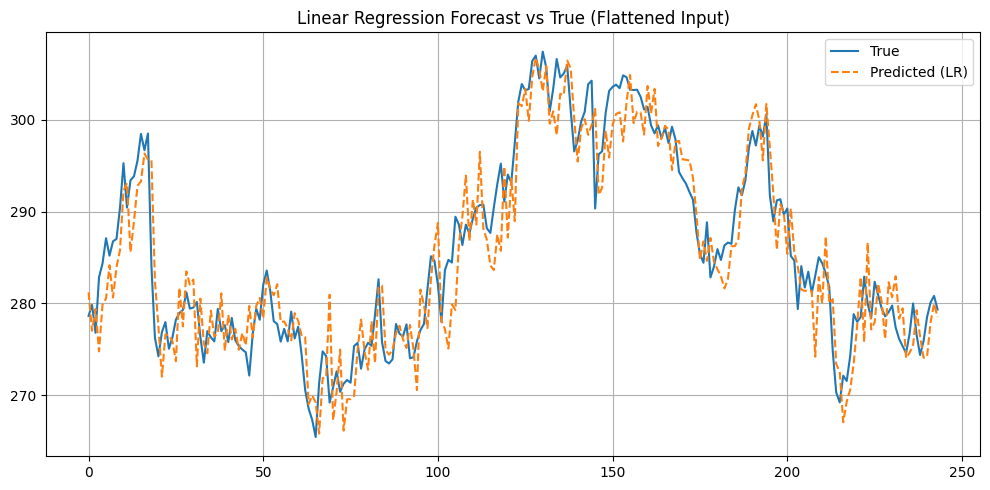

In [56]:
# Flatten 3D input into 2D: (samples, timesteps * features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Initialize and train Linear Regression model
lr_model_flat = LinearRegression()
lr_model_flat.fit(X_train_flat, y_train)

# Predict and inverse transform
lr_y_pred_flat = lr_model_flat.predict(X_val_flat)
lr_y_pred_flat_inv = y_scaler.inverse_transform(lr_y_pred_flat.reshape(-1, 1))
lr_y_val_inv = y_scaler.inverse_transform(y_val)

# Evaluation
lr_rmse = np.sqrt(mean_squared_error(lr_y_val_inv, lr_y_pred_flat_inv))
lr_mae = mean_absolute_error(lr_y_val_inv, lr_y_pred_flat_inv)
lr_r2 = r2_score(lr_y_val_inv, lr_y_pred_flat_inv)

print("📊 Linear Regression (flattened GRU input) Performance:")
print(f"RMSE: {lr_rmse:.4f}, MAE: {lr_mae:.4f}, R²: {lr_r2:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(lr_y_val_inv, label='True')
plt.plot(lr_y_pred_flat_inv, label='Predicted (LR)', linestyle='--')
plt.legend()
plt.title("Linear Regression Forecast vs True (Flattened Input)")
plt.tight_layout()
plt.grid(True)
plt.show()

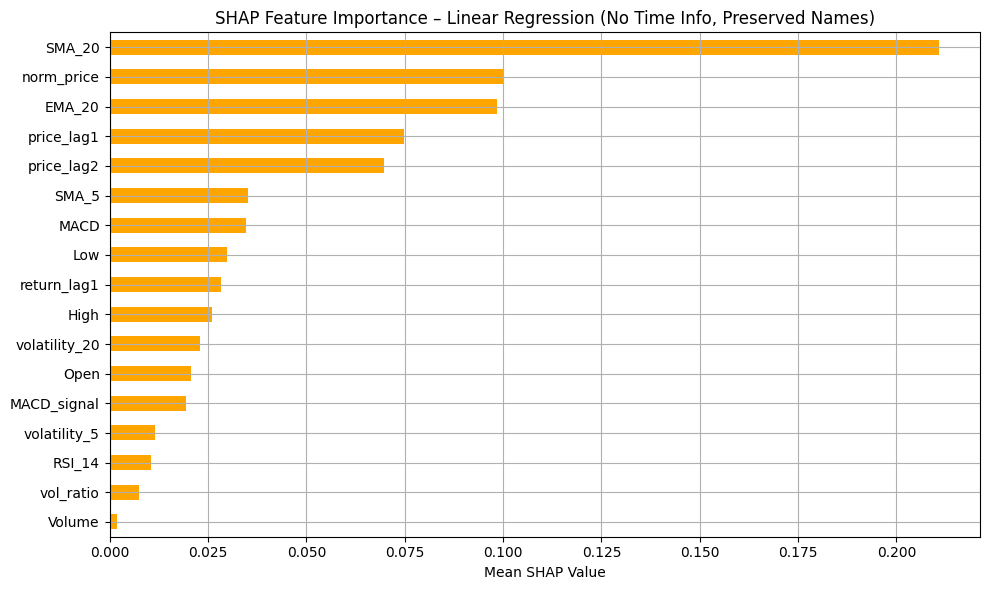

In [58]:
# Step 2: Generate flattened feature names preserving time info
flat_feature_names = []
for t in range(X.shape[1]):
    for f in feature_cols:
        flat_feature_names.append(f"{f}_t{t+1}")  # e.g., "SMA_20_t1"

# Step 4: Run SHAP Explainer
X_train_df = pd.DataFrame(X_train_flat, columns=flat_feature_names)
X_val_df = pd.DataFrame(X_val_flat, columns=flat_feature_names)

explainer = shap.Explainer(lr_model_flat, X_train_df)
shap_values = explainer(X_val_df)

# Step 5: Convert SHAP values to DataFrame and group by base feature name (removing _tN)
shap_df = pd.DataFrame(np.abs(shap_values.values), columns=flat_feature_names)

# Remove time index and group
base_feature_names = [name.split("_t")[0] for name in shap_df.columns]
shap_df.columns = base_feature_names

# Now aggregate: mean across columns with the same base feature name
mean_shap_per_feature = shap_df.groupby(shap_df.columns, axis=1).mean().mean(axis=0)

# Step 6: Plot
plt.figure(figsize=(10, 6))
mean_shap_per_feature.sort_values().plot(kind='barh', color='orange')
plt.xlabel("Mean SHAP Value")
plt.title("SHAP Feature Importance – Linear Regression (No Time Info, Preserved Names)")
plt.tight_layout()
plt.grid(True)
plt.show()

# Build Multivariate Linear Regression (Custom Optimized)

- Build a separate Linear Regression model using handcrafted lag and technical indicator feature from `stock_df` to predict the next day's closing price.

📊 Linear Regression (custom features) Performance:
RMSE: 3.1010, MAE: 2.4153, R²: 0.9116


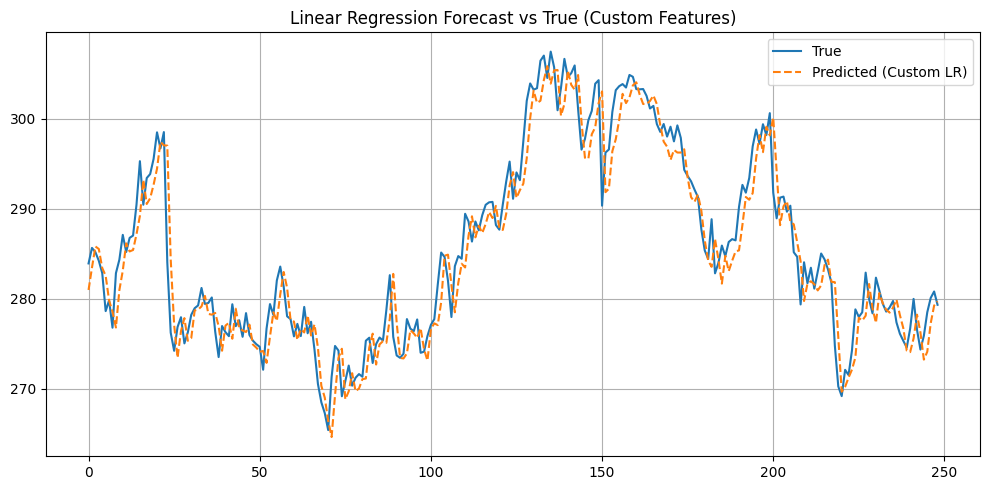

In [59]:
# Define features and target
custom_lr_features = [
     'Volume', 'Open', 'High', 'Low', 'RSI_14', 'MACD', 'MACD_signal',
            'SMA_5', 'SMA_20', 'EMA_20', 'norm_price', 'price_lag1', 'price_lag2',
            'return_lag1', 'volatility_5', 'volatility_20', 'vol_ratio'
]

# Define target: 1-day ahead closing price
stock_df['target_next_day'] = stock_df['Close'].shift(-1)

# Drop NA due to shift
custom_df = stock_df[custom_lr_features + ['target_next_day']].dropna().copy()

# Split into train/test
split_idx = int(len(custom_df) * 0.8)
X_custom_train = custom_df.iloc[:split_idx][custom_lr_features]
X_custom_val = custom_df.iloc[split_idx:][custom_lr_features]
y_custom_train = custom_df.iloc[:split_idx]['target_next_day']
y_custom_val = custom_df.iloc[split_idx:]['target_next_day']

# Train Linear Regression
lr_model_custom = LinearRegression()
lr_model_custom.fit(X_custom_train, y_custom_train)

# Predict and evaluate
y_custom_pred = lr_model_custom.predict(X_custom_val)

custom_rmse = np.sqrt(mean_squared_error(y_custom_val, y_custom_pred))
custom_mae = mean_absolute_error(y_custom_val, y_custom_pred)
custom_r2 = r2_score(y_custom_val, y_custom_pred)

print("📊 Linear Regression (custom features) Performance:")
print(f"RMSE: {custom_rmse:.4f}, MAE: {custom_mae:.4f}, R²: {custom_r2:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_custom_val.values, label='True')
plt.plot(y_custom_pred, label='Predicted (Custom LR)', linestyle='--')
plt.legend()
plt.title("Linear Regression Forecast vs True (Custom Features)")
plt.tight_layout()
plt.grid(True)
plt.show()

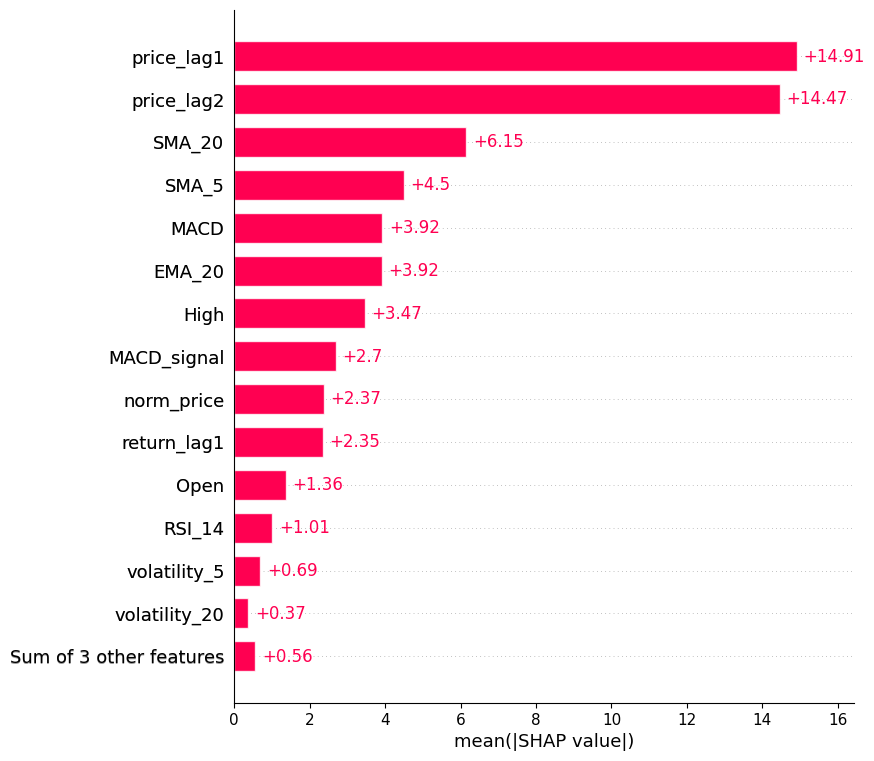

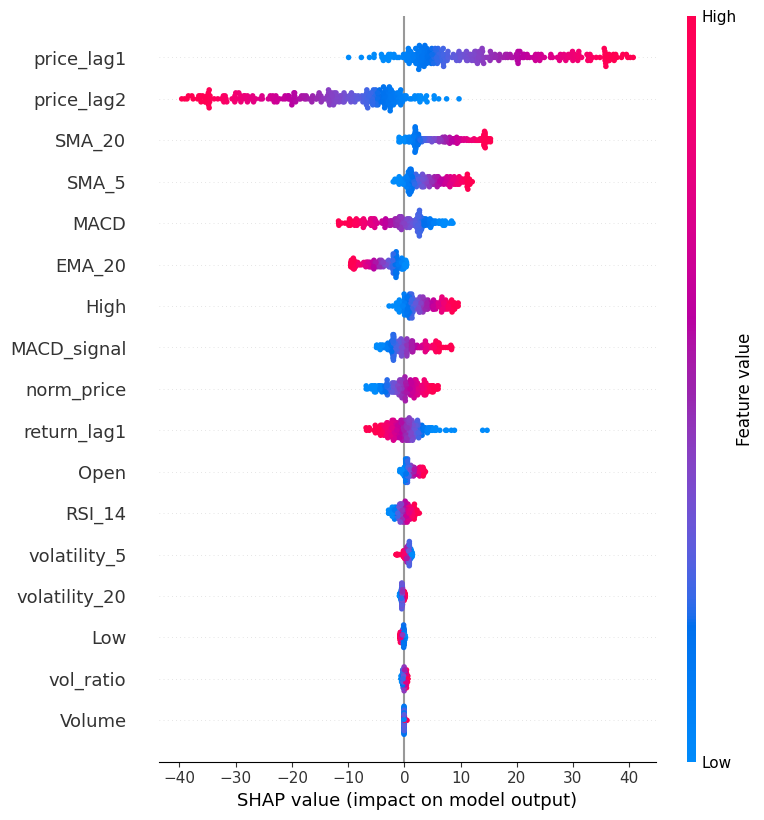

In [63]:
explainer = shap.Explainer(lr_model_custom, X_custom_train)
shap_values_custom = explainer(X_custom_val)

# Only show the SHAP summary bar plot (preferred)
shap.plots.bar(shap_values_custom, max_display=15)

# Summary plot (beeswarm plot)
shap.summary_plot(shap_values_custom, X_custom_val)

# Further Evaluation - Sharpe Ratio & Cumulative Returns